In [1]:
import os
import numpy as np 
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)

from IPython.display import clear_output

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

rootDir = "D:/바탕화면/Dataset/TUG/trainSet"
expertFolder = "/" + "2021_01_24_saveResults_최윤정"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

 [Home Dir.] Current path D:\바탕화면\conda\tug\own\tug-main\0_temporalCNN_wLabel
 Current workaing path [dataset]  D:\바탕화면\Dataset\TUG\trainSet\2021_01_24_saveResults_최윤정\0_sideView


### Train/Test Set -- subject 기준으로 분할   
##### (Kfold_num = 0 이면 직접 분할, 5 등 숫자면 5-fold dataset)

Key    
    https://github.com/ashishpatel26/tcn-keras-Examples  

sub  
      https://www.programmersought.com/article/13674618779/  

In [2]:
def trainData_split(datasetDir,train_ratio = 0.6, valid_ratio=0.2, shuffle = False,  Kfold_num = 5):      
    expDates = next(os.walk(datasetDir))[1]   #['2020_11_03', '2020_11_20_v1', '2020_11_20_v2', '2020_11_23', '2020_12_09', '2020_12_30']
    
    subject_number = 0
    subjects_list = []
    
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder)   # D:/바탕화면/Dataset/TUG/trainSet/2021_01_24_saveResults_최윤정/0_sideView\2020_11_03
        tmpSubjects = next(os.walk(dateDir))[1]
        subjects_list.append(tmpSubjects)  
        subject_number += len(tmpSubjects)

    # ------ 2D -> 1D [[sub1, sub2], [sub3, sub4]] -> [sub1, sub2, sub3, sub4]
    subjects = []
    for eachSub in subjects_list:
        subjects += eachSub
    print(" [before shuffle] 1D sub list: " , subjects)

    if shuffle:
        np.random.shuffle(subjects)
        print(" [After shuffle] 1D sub list: " , subjects)
            

#     # --- K-fold cross validation
    
    if Kfold_num is not 0:
        Fold_results =[]
        print(" [K-Fold] K = ", Kfold_num)
        kfold = KFold(n_splits=  Kfold_num)
        for trainIdx, testIdx in kfold.split(subjects):
            Fold_results.append([trainIdx, testIdx])        
        train_Fold= []
        test_Fold = []
        
        for i in range(Kfold_num):
            tmp_train = []
            tmp_test = []
            for subIdx in range(len(subjects)): 
                if subIdx in Fold_results[i][0]:  # 
                    tmp_train.append(subjects[subIdx])
                    
                if subIdx in Fold_results[i][1]:  # -- K-fold test
                    tmp_test.append(subjects[subIdx])
          
            train_Fold.append(tmp_train)
            test_Fold.append(tmp_test)
            print("\t [process]", i, "-fold:", train_Fold[i], "\n\t\t\t   ,", test_Fold[i])
        print("\n [results]  trainSet: ", len(train_Fold[0]) , " 명 , testSet: ", len(test_Fold[0]), " 명" )
        return train_Fold, test_Fold

        
    else:
                # ---- Split train/test subjects (for arbitrary split)
        trainSub_number = np.round( (len(subjects)*train_ratio), 0).astype(int)
        validSub_number = np.round( (len(subjects)*valid_ratio), 0).astype(int)
        testSub_number = subject_number - trainSub_number - validSub_number
        
        print("--------- no fold ----")
        train_subjects = subjects[ :trainSub_number]
        valid_subjects = subjects[ trainSub_number : (trainSub_number+validSub_number)]
        test_subjects = subjects[ (trainSub_number+validSub_number): ]
        print("[results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
        print("\n\t--> # of train  : " + str(trainSub_number) +" 명 ,  # of valid : "+ str(validSub_number) + " 명 ,  # of test :" + str(testSub_number) + "명")
        return train_subjects, valid_subjects, test_subjects 


def getPelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:9]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

def create_dataset(train_subjects, valid_subjects, test_subjects):
    train_x = np.zeros((0, numFeature))
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, numFeature))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, numFeature))
    test_y = np.zeros((0, numActions))    
    
    for dirpath, foldername, files in os.walk(datasetDir):
        for filename in files:
            if "lpf_" in filename:
                subname = dirpath.split("\\")[2] 
                csvFile = os.path.join(dirpath, filename)
                timestamp, pelvis_x, pelvis_y, pelvis_z, actionList = getPelvisData(csvFile) 
                
                pelvisData = np.array([pelvis_x, pelvis_y, pelvis_z]).T
                actionData = np.array(actionList)
                #dataset = tf.data.Dataset.from_tensor_slices( (pelvisData.astype('float32'), actionData.astype('float32')) ) 
                dataset = np.zeros( (len(pelvisData), dataset_columns) ) 
                
                dataset[:, :-(numActions)] = pelvisData      # time , pelvis  넣음  (317,4) -- raw data 
                dataset[:, -(numActions): ] = actionData     # (335, 5) one hot encoding 수행한 actionsList
                
                if Kfold_num==0:
                    if subname in train_subjects:
                        train_x = np.append(train_x, pelvisData, axis = 0 )
                        train_y = np.append(train_y, actionData, axis = 0 )

                    elif subname in valid_subjects:
                        valid_x = np.append(valid_x, pelvisData, axis = 0 )
                        valid_y = np.append(valid_y, actionData, axis = 0 )

                    elif subname in test_subjects:
                        test_x = np.append(test_x, pelvisData, axis = 0 )
                        test_y = np.append(test_y, actionData, axis = 0 )    
                else:
                    if subname in train_subjects:
                        train_x = np.append(train_x, pelvisData, axis = 0 )
                        train_y = np.append(train_y, actionData, axis = 0 )
                    elif subname in test_subjects:
                        test_x = np.append(test_x, pelvisData, axis = 0 )
                        test_y = np.append(test_y, actionData, axis = 0 )   

    return train_x, train_y, valid_x, valid_y, test_x, test_y 


In [3]:
# ---------------  1. subject 별로 dataset 분할 (K-fold 정함) ------------------------------------------------------#

train_ratio = 0.6
valid_ratio = 0.2

Kfold_num = 0 # if kfold_num = 0 (arbitrary train/test set will be used)s
arbitrary_dataset = True

numFeature = 3
numActions = 5
dataset_columns = numFeature + numActions

if Kfold_num == 0:
    if arbitrary_dataset:

#         normal_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'lhs', 'NHJ_60', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj', 'cyj2', 'jdh', 'jek', 'kch', 'ryu'] 
#         patients_subjects = ['JDW_tug']
#         copy_patients_subjects = ['BYS_TUG', 'CYJ_TUG', 'PHE_TUG', 'YSJ_TUG'] 


#         train_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj','BYS_TUG', 'CYJ_TUG'] 
#         valid_subjects = ['cyj2', 'jdh', 'jek', 'PHE_TUG','lhs' ] 
#         test_subjects =  ['kch', 'ryu', 'JDW_tug', 'YSJ_TUG','NHJ_60']

        train_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj', ] 
        valid_subjects = ['cyj2', 'jdh', 'jek', 'lhs' ] 
        test_subjects =  ['kch', 'ryu', 'NHJ_60']
        
        
    else:
        train_subjects, valid_subjects, test_subjects = trainData_split(datasetDir, train_ratio = train_ratio, valid_ratio=valid_ratio, shuffle = False, Kfold_num = Kfold_num)
        
    train_x, train_y, valid_x, valid_y, test_x, test_y = create_dataset(train_subjects, valid_subjects, test_subjects )
    print("\n [Train] X - {0} , Y - {1} \t [Valid] X - {2}, Y - {3} \t [Test] X - {4} , Y - {5}".format(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape))
    
else: 
    train_fold, test_fold = trainData_split(datasetDir, shuffle = False, Kfold_num = Kfold_num) 
    print("\n\n -------------------- K-Fold Dataset ------------------------ ")
    folds_dataset = []
    for i in range(Kfold_num):
        train_x, train_y, test_x, test_y = create_dataset(train_fold[i])
        print(" \t Train (X,Y): {0} , {1} \t Test (X,Y): {2} , {3}".format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))
        folds.append((train_x, train_y, test_x, test_y)) # --- 수정 필요할듯
    print(np.array(folds[0][0]).shape)


 [Train] X - (48453, 3) , Y - (48453, 5) 	 [Valid] X - (16672, 3), Y - (16672, 5) 	 [Test] X - (11403, 3) , Y - (11403, 5)


In [4]:
from sklearn.preprocessing import MinMaxScaler
# import tqdm

lookback_window = 3



def sliding_window(data_x, data_y, lookback_window=15):
    x = []
    y = []
    enc = MinMaxScaler(feature_range = (0, 1))
    enc_y = enc.fit_transform(data_y)
    for i in range(lookback_window, len(data_x)):
        x.append(data_x[i - lookback_window:i])
        y.append(data_y[i])
        
    x = np.array(x)
    y = np.array(y)
    
    x = x.reshape(-1, lookback_window, 3, 1)
#     y = y.reshape(-1, 5, 1)
    return x, y, enc


x_train, y_train, enc_train = sliding_window(train_x, train_y,  lookback_window=lookback_window) # (57207, 15, 3)
x_valid, y_valid, enc_valid = sliding_window(valid_x, valid_y,  lookback_window=lookback_window)
x_test, y_test, enc_test = sliding_window(test_x, test_y, lookback_window=lookback_window)
print("x_train: ", x_train.shape," , y_train: ", y_train.shape)
print("x_valid: ",x_valid.shape, " , y_valid: ",y_valid.shape)
print("x_test: ",x_test.shape, "  , y_test: ",y_test.shape)


x_train:  (48450, 3, 3, 1)  , y_train:  (48450, 5)
x_valid:  (16669, 3, 3, 1)  , y_valid:  (16669, 5)
x_test:  (11400, 3, 3, 1)   , y_test:  (11400, 5)


### Model Build

In [5]:
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping

from tcn import TCN

In [6]:
MODEL_SAVE_FOLDER_PATH = rootDir + "/"+ expertFolder +"/model_TCN/"

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "WinSize- "+ str(lookback_window) +"TUG-" + "{epoch:02d} ---- {val_loss: .4f}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=15)

D:/바탕화면/Dataset/TUG/trainSet//2021_01_24_saveResults_최윤정/model_TCN/


In [7]:

 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(train_x,train_y, valid_x, valid_y, test_x,test_y,class_weight):
    kernel_size = (3,3)
    input_shape =  (lookback_window, 3, 1) # (3, 8, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(5, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(train_x,train_y,batch_size= 500, epochs=100,verbose=2, validation_data= (valid_x, valid_y),  callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)

    eval_result = model.evaluate(test_x,test_y,batch_size= 500,verbose=2)
#     eval_result = model.evaluate(valid_x,valid_y,batch_size=200,verbose=2)
    
    return model, eval_result, hist


In [8]:
 # (feature, sliding_window, 1) ...TCN,,,  
class_weight = {0:0.21, 1:0.06, 2:0.5, 3:0.14, 4:0.09}
model, eval_result, hist = TCN(x_train,y_train, x_valid, y_valid, x_test, y_test, class_weight)
print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 3, 32)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 32)     9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 3, 32)     320         input_1[0][0]                    
_______________________________________________________________________________________

In [9]:
# y_pred = model.predict(x_test)
y_pred = model.predict(x_test)
print(y_pred.shape)

y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])


(11400, 5)
[0.     0.     0.9999 0.0001 0.    ] ===> onehot:  2


### 현재 결론: 환자/모방환자 data 를 train set에 포함 시 acc 90% , data balance가 맞지 않으면 85% 정도.. 
### 추가로 환자 data 더 넣어볼 것

In [15]:
# print(hist.history['loss'])
# print(hist.history['accuracy'])
# print(hist.history['val_loss'])
# print(hist.history['val_accuracy'])

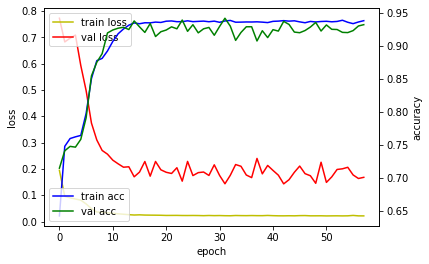

In [11]:

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()


### Confusion Matrix, Precision, Recall, F1 score

In [12]:
y_test_argmax = np.argmax(y_test ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)

def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3, "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0, "stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])


    
    return action_cnt
    
y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

(11400,) (11400,)
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.25201754385964914
	 [ 1 - sit-stand] ratio of sit-stand:  0.04964912280701755
	 [ 2 - walk] ratio of walk:  0.4937719298245614
	 [ 3 - turn] ratio of turn:  0.12140350877192982
	 [ 4 - stand-sit] ratio of stand-sit:  0.08315789473684211
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.23640350877192984
	 [ 1 - sit-stand] ratio of sit-stand:  0.0669298245614035
	 [ 2 - walk] ratio of walk:  0.4637719298245614
	 [ 3 - turn] ratio of turn:  0.13736842105263158
	 [ 4 - stand-sit] ratio of stand-sit:  0.09552631578947368
--->  # of Each Action Frames  
	 y_pred: {'total_frames': 11400, 'sit': 2873, 'sit-stand': 566, 'walk': 5629, 'turn': 1384, 'stand-sit': 948}, 
	 y_test: {'total_frames': 11400, 'sit': 2695, 'sit-stand': 763, 'walk': 5287, 'turn': 1566, 'stand-sit': 1089}


Cohens kappa: 0.900663
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2695
           1       0.97      0.72      0.82       763
           2       0.92      0.98      0.95      5287
           3       0.96      0.85      0.90      1566
           4       0.95      0.82      0.88      1089

    accuracy                           0.93     11400
   macro avg       0.94      0.87      0.90     11400
weighted avg       0.93      0.93      0.93     11400


---> Confusion Matrix 
 [[2671    9    0    0   15]
 [ 151  548   64    0    0]
 [   0    9 5184   57   37]
 [   0    0  239 1327    0]
 [  51    0  142    0  896]]


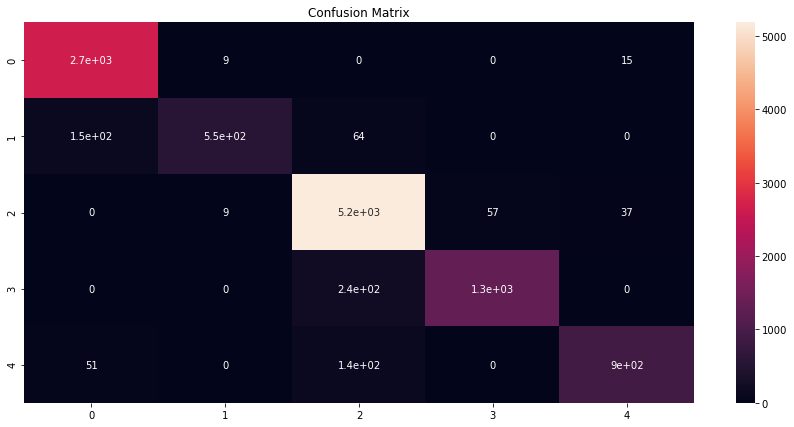

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))

conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.show()

import matplotlib.pyplot as plt

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()